# Final Exam - Open

## FINM 37500 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* You have `100` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

The exam uses the following file,
`data/fiderivs_2025-03-10.xlsx`

- Section 1 uses the following sheets:
    * `rate curves`
    * quarterly spaced and quarterly compounded rates

- Section 2 uses the following sheets:
    * `rate tree`
    * continuously-compounded rate tree

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 75     |
| 2       | 25     |

Numbered problems are worth 5pts unless specified otherwise.

***

## Submitting your Exam

Submission
* You will upload your solution to the `Exam - Open` assignment on Canvas. 
* Submit a compressed, "zipped", folder containing all code according to the file structure below.
* Name your submitted, zipped, folder `exam-open-LASTNAME-FIRSTNAME.zip`.
* Be sure to **submit** on Canvas, not just **save** on Canvas.

Your submission should **include all code and data used in your analysis** in the following folder structure.
* We strongly prefer all submissions are structred this way, and it will improve grading accuracy for partial credit. 
* Still, if you're struggling to get this working in time, no worries; just structure as comfortable and submit **everything used** for your submission.

__Exam Submission Structure:__

```plaintext
exam-open-LASTNAME-FIRSTNAME.zip/
│── exam-open.ipynb
│── data/
│   ├── example_data.csv
│── modules/
│   ├── my_functions.py

### Validating your folder structure

The next cell tests that you have this folder structure implemented.

In [1]:
from pathlib import Path
import sys
import pandas as pd

# Get the directory of the notebook (assumes Jupyter Notebook is always used)
BASE_DIR = Path().resolve()

# Define paths for data and modules
DATA_DIR = BASE_DIR / "data"
MODULES_DIR = BASE_DIR / "modules"

# Check if expected directories exist
if not DATA_DIR.exists():
    print(f"Warning: Data directory '{DATA_DIR}' not found. Check your file structure.")

if not MODULES_DIR.exists():
    print(f"Warning: Modules directory '{MODULES_DIR}' not found. Check your file structure.")

# Ensure Python can import from the modules directory
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

# Load exam data
EXAMPLE_DATA_PATH = DATA_DIR / "fiderivs_2025-03-10.xlsx"

if EXAMPLE_DATA_PATH.exists():
    example_data = pd.read_excel(EXAMPLE_DATA_PATH)
else:
    print(f"Warning: '{EXAMPLE_DATA_PATH.name}' not found. Ensure it's in the correct directory.")


***

# 1.

Consider the following rate data.

In [116]:
DATE = '2025-03-10'
FILEIN = f'./data/fiderivs_{DATE}.xlsx'

sheet_curves = f'rate curves'

curves = pd.read_excel(FILEIN, sheet_name=sheet_curves).set_index('tenor')
# curves_new_new.drop(columns=['fwd vols'],inplace=True)
curves.style.format('{:.1%}').format_index('{:.2f}')

,swap rates,spot rates,discounts,forwards,flat vols
tenor,,,,,
0.25,4.2%,4.2%,99.0%,nan%,nan%
0.50,4.1%,4.1%,98.0%,4.0%,14.6%
0.75,4.0%,4.0%,97.1%,3.7%,16.9%
1.00,3.9%,3.9%,96.2%,3.6%,19.1%
1.25,3.8%,3.8%,95.4%,3.4%,22.2%
1.50,3.7%,3.7%,94.6%,3.4%,24.5%
1.75,3.7%,3.7%,93.8%,3.4%,26.1%
2.00,3.7%,3.7%,93.0%,3.5%,27.2%
2.25,3.6%,3.6%,92.2%,3.4%,27.9%


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [118]:
def price_bond(discounts: pd.DataFrame, cpnrate: float, ttm: float, cpnfreq: int = 2, face: float = 100) -> float:
    """
    Prices a typical coupon bond using discount factors.
    
    Parameters:
        discounts (pd.DataFrame): A dataframe with an index representing time-to-maturity (in years)
                                  at intervals (e.g., 0.5, 1.0, ..., 30), and with columns 'spot rate' and 'discount'.
        cpnrate (float): Annual coupon rate. If the value is greater than 1, it is assumed to be a percentage
                         and will be divided by 100.
        ttm (float): Time-to-maturity (in years) of the bond.
        cpnfreq (int, optional): Number of coupon payments per year (default=2 for semiannual coupons).
        face (float, optional): Face (par) value of the bond (default=100).
    
    Returns:
        float: The calculated bond price.
    """
    
    # Adjust coupon rate if provided as a percentage
    if cpnrate > 1:
        cpnrate = cpnrate / 100.0

    coupon_payment = face * cpnrate / cpnfreq

    # If time-to-maturity is less than one coupon period, set payment_dates to just [ttm]
    if ttm < 1/cpnfreq:
        payment_dates = np.array([ttm])
    else:
        # Generate regular coupon payment dates
        payment_dates = np.arange(1/cpnfreq, ttm + 1e-8, 1/cpnfreq)
        # If the last payment date is not exactly ttm, add the maturity as an irregular final period.
        if not np.isclose(payment_dates[-1], ttm):
            payment_dates = np.append(payment_dates, ttm)
    
    price = 0.0
    for t in payment_dates:
        # Determine cash flow:
        # For the final payment at maturity, add the face value.
        # Note: Depending on the bond's terms, you might want to prorate the coupon for an irregular period.
        if np.isclose(t, ttm):
            cash_flow = coupon_payment + face
        else:
            cash_flow = coupon_payment
        
        # Retrieve the discount factor: if an exact match is not found, interpolate.
        if t in discounts.index:
            discount_factor = discounts.loc[t, 'discount']
        else:
            discount_factor = np.interp(t, discounts.index.values, discounts['discount'].values)
        
        price += cash_flow * discount_factor
    
    return price

### 1.1.

Price a fixed-rate bond with the following specifications...
* T = `5`
* coupons are paid `quarterly`.
* coupon rate is `3.6%` (quarterly).

Note: 
* Use the discount curves provided.
* Use the usual bond-pricing formula.
* The clean and dirty price are the same, as we assume the bond has just been issued.

In [159]:
T = 5
cpnrate = 0.036
cpnfreq = 4

discs = curves[['discounts']].rename(columns={'discounts': 'discount'})
bond_price = price_bond(discounts = discs, cpnrate = cpnrate, ttm = T, cpnfreq = cpnfreq) 
print(f"The price of a {T}-year bond with a {cpnrate:.2%} coupon rate is: {bond_price:.2f}")

The price of a 5-year bond with a 3.60% coupon rate is: 99.94


### 1.2.

As usual, the provided cap/floor quotes correspond to caps/floors...
* notional of `$100`
* struck at-the-money, `ATM`.
* with expiration `T`.
* with `quarterly` caplets / floorlets.
* depending on the reference rate, in arrears.

Note that, as usual,
* We assume that the reference rate is compounded the same as the interest rates in the provided data. Thus, no adjustment is needed to the compounding.

Calculate and report the forward volatilities stripped from the caps.

In [15]:
import sys
sys.path.insert(0, '../../cmds')
from fiderivs import *
from ratecurves import *
from ficcvol import *

,flat vols,fwd vols
tenor,,
0.25,nan%,nan%
0.50,14.6%,14.6%
0.75,16.9%,18.7%
1.00,19.1%,22.3%
1.25,22.2%,29.0%
1.50,24.5%,30.7%
1.75,26.1%,31.5%
2.00,27.2%,31.5%
2.25,27.9%,30.7%


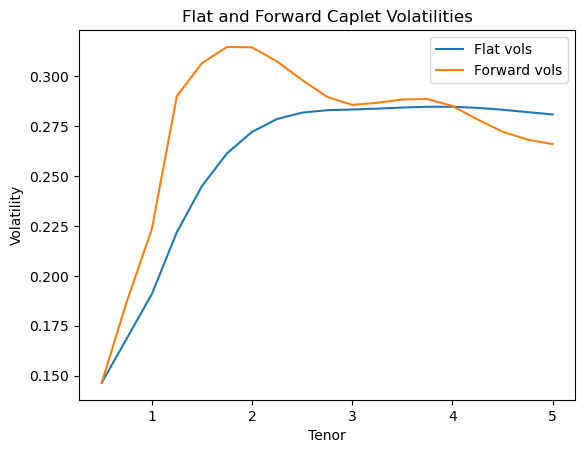

In [160]:
N = 100
capcurves = flat_to_forward_vol(curves)
display(capcurves[["flat vols", "fwd vols"]].style.format('{:.1%}').format_index('{:.2f}'))
plt.plot(capcurves.index, capcurves['flat vols'], label='Flat vols')
plt.plot(capcurves.index, capcurves['fwd vols'], label='Forward vols')
plt.xlabel('Tenor')
plt.ylabel('Volatility')
plt.title('Flat and Forward Caplet Volatilities')
plt.legend()    
plt.show()

### 1.3. (15pts)

Price caps and floors continuing with the assumptions above. Except calculate the prices for a range of strikes...

* cap struck `ATM`.
* floor struck `ATM`.
* cap struck `+150bps`.
* floor struck `-150bps`.

Report the 
* three strikes, ATM adjusted by (-150, 0, +150).
* the dollar value of the four instruments.

Note that 
* you do not need the forward vols calculated in `1.2` to price these caps/floors. The flat vols are sufficient.

In [161]:
def blacks_formula(T, vol, strike, fwd, discount=1.0, isCall=True):

    if T <= 0 or vol <= 0:
        intrinsic = (fwd - strike) if isCall else (strike - fwd)
        return discount * max(intrinsic, 0.0)
    
    sigT = vol * np.sqrt(T)
    d1 = (np.log(fwd / strike)) / sigT + 0.5 * sigT
    d2 = d1 - sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val


def price_floorlet_caplert(T_pay, vol, strike, fwd, discount, notional=100, freq=4, capletr = True):

    dt = 1.0 / freq
    T_expiry = T_pay - dt
    pv = notional * dt * blacks_formula(
        T_expiry, vol, strike, fwd, discount, isCall=capletr
    )
    return pv

def price_floor_cap(T_final, vol, strike, forwards, discounts, notional=100, freq=4, cap = True):

    dt = 1.0 / freq
    floor_val = 0.0
    floorlets = pd.DataFrame()
    n_quarters = int(round(T_final * freq))
    if cap == True:
        name = "capletrs"
    else:
        name = "floorlet"
    for i in range(2, n_quarters + 1):  
        t_pay = dt * i
        if t_pay > T_final:
            break
        
        fwd_t    = forwards.loc[t_pay]    
        disc_t   = discounts.loc[t_pay]   
        floorlet = price_floorlet_caplert(
            T_pay=t_pay, vol=vol, strike=strike,
            fwd=fwd_t, discount=disc_t,
            notional=notional, freq=freq, capletr = cap
        )
        floor_val += floorlet
        floorlets.loc[t_pay, name] = floorlet
    return floor_val, floorlets

In [162]:
T = 5.0
SHIFT = +150/100/100
K_ATM = curves.loc[T, 'swap rates'] 
vol_flat = curves.loc[T, 'flat vols']  # For floor use flat vols

CAP_ATM, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = True
)


CAP_plus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM + SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = True
)

CAP_minus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM - SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = True
)

FLOOR_ATM, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = False
)

FLOOR_minus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM - SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = False
)

FLOOR_plus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM + SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = False
)

results = pd.DataFrame({
    'ATM': [CAP_ATM, FLOOR_ATM],
    '+150bps': [CAP_plus_150bps, FLOOR_plus_150bps],
    '-150bps': [CAP_minus_150bps, FLOOR_minus_150bps]
}, index=['Caplets', 'Floorlets'])

In [163]:
display(results.style.format('{:.4f}'))

,ATM,+150bps,-150bps
Caplets,2.4920,0.9130,6.6221
Floorlets,2.6421,7.5219,0.3136


### 1.4.

Price a portfolio comprised of the positions in the table. (The positions are listed as "contracts" where each contract has face or notional of $100.)

In [177]:
contracts = pd.DataFrame(data=[1,1,-1,-1,1],columns = ['contracts'],index=["bond", "cap ATM", "floor ATM", "cap OTM", "floor OTM"])
contracts.style.format('{:.0f}',na_rep='')

,contracts
bond,1
cap ATM,1
floor ATM,-1
cap OTM,-1
floor OTM,1


In [178]:
contracts.loc["bond", "price"] = bond_price
contracts.loc["cap ATM", "price"] = CAP_ATM
contracts.loc["floor ATM", "price"] = FLOOR_ATM
contracts.loc["cap OTM", "price"] = CAP_plus_150bps
contracts.loc["floor OTM", "price"] = FLOOR_minus_150bps

contracts["portfolio"] = contracts["contracts"] * contracts["price"]
portfolio_value = contracts["portfolio"].sum()
display(contracts.style.format('{:.2f}'))
print(f"The value of the portfolio is: {portfolio_value:.2f}")

,contracts,price,portfolio
bond,1.00,99.94,99.94
cap ATM,1.00,2.49,2.49
floor ATM,-1.00,2.64,-2.64
cap OTM,-1.00,0.91,-0.91
floor OTM,1.00,0.31,0.31


The value of the portfolio is: 99.19


### 1.5. (10pts)

Suppose all spot rates are shocked by 1bp.

Report the new
* discount factors
* forward rates
* swap rates

(The latter two should still be quarterly compounded.)

Note that...
* We are not revising flat or forward vols.

In [166]:
curves_new = curves.copy()
curves_new['spot rates shocked'] = curves_new['spot rates'] + 0.0001


def discount_factor_qtrly(spot, T):
    return (1.0 + spot / 4.0) ** (-4.0 * T)

curves_new['discounts shocked'] = [
    discount_factor_qtrly(curves_new.loc[T, 'spot rates shocked'], T)
    for T in curves_new.index
]


forward_shocked = []
discount_shocked_vals = curves_new['discounts shocked'].values
for i, T in enumerate(curves_new.index):
    if i == 0:
        forward_shocked.append(np.nan)
    else:
        fwd = 4.0 * (discount_shocked_vals[i-1] / discount_shocked_vals[i] - 1.0)
        forward_shocked.append(fwd)

curves_new['forwards shocked'] = forward_shocked


def swap_rate_qtrly(T, discount_vector, dt=0.25):

    accrued_leg = 0.25 * np.sum(discount_vector)
    df_final = discount_vector[-1]
    return (1.0 - df_final) / accrued_leg

new_swap_rates = []
for i in range(len(curves_new)):
    discount_slice = discount_shocked_vals[: i+1]
    T = curves_new.index[i]
    new_swap = swap_rate_qtrly(T, discount_slice)
    new_swap_rates.append(new_swap)

curves_new['swap rates shocked'] = new_swap_rates



curves_new = curves_new.drop(columns = ['spot rates', 'forwards', 'discounts', 'swap rates'])
curves_new.rename(columns = {'forwards shocked': 'forwards', 'swap rates shocked': 'swap rates', 'discounts shocked': 'discounts', "spot rates shocked" : "spot rates"}, inplace=True)
display(curves_new)

,flat vols,spot rates,discounts,forwards,swap rates
tenor,,,,,
0.25,NaN,0.042292,0.989538,NaN,0.042292
0.50,0.146300,0.041023,0.979800,0.039755,0.041030
0.75,0.168563,0.039844,0.970703,0.037487,0.039860
1.00,0.190826,0.038908,0.962020,0.036101,0.038933
1.25,0.221870,0.037930,0.953907,0.034018,0.037968
1.50,0.244993,0.037279,0.945861,0.034028,0.037325
1.75,0.261375,0.036867,0.937798,0.034393,0.036917
2.00,0.272194,0.036624,0.929680,0.034928,0.036676
2.25,0.278629,0.036327,0.921855,0.033953,0.036384


### 1.6. (10pts)

Calculate the numerical duration.
* increase all the spot rates by 1bp. 
* use the revised rates from `1.5.` corresponding to this shock.
* re-price the portfolio.

Report the 
* esitmated duration for each component of the portfolio.
* duration of the total portfolio.

In [167]:
def price_bond(discounts: pd.DataFrame, cpnrate: float, ttm: float, cpnfreq: int = 2, face: float = 100) -> float:
    """
    Prices a typical coupon bond using discount factors.
    
    Parameters:
        discounts (pd.DataFrame): A dataframe with an index representing time-to-maturity (in years)
                                  at intervals (e.g., 0.5, 1.0, ..., 30), and with columns 'spot rate' and 'discount'.
        cpnrate (float): Annual coupon rate. If the value is greater than 1, it is assumed to be a percentage
                         and will be divided by 100.
        ttm (float): Time-to-maturity (in years) of the bond.
        cpnfreq (int, optional): Number of coupon payments per year (default=2 for semiannual coupons).
        face (float, optional): Face (par) value of the bond (default=100).
    
    Returns:
        float: The calculated bond price.
    """
    
    # Adjust coupon rate if provided as a percentage
    if cpnrate > 1:
        cpnrate = cpnrate / 100.0

    coupon_payment = face * cpnrate / cpnfreq

    # If time-to-maturity is less than one coupon period, set payment_dates to just [ttm]
    if ttm < 1/cpnfreq:
        payment_dates = np.array([ttm])
    else:
        # Generate regular coupon payment dates
        payment_dates = np.arange(1/cpnfreq, ttm + 1e-8, 1/cpnfreq)
        # If the last payment date is not exactly ttm, add the maturity as an irregular final period.
        if not np.isclose(payment_dates[-1], ttm):
            payment_dates = np.append(payment_dates, ttm)
    
    price = 0.0
    for t in payment_dates:
        # Determine cash flow:
        # For the final payment at maturity, add the face value.
        # Note: Depending on the bond's terms, you might want to prorate the coupon for an irregular period.
        if np.isclose(t, ttm):
            cash_flow = coupon_payment + face
        else:
            cash_flow = coupon_payment
        
        # Retrieve the discount factor: if an exact match is not found, interpolate.
        if t in discounts.index:
            discount_factor = discounts.loc[t, 'discount']
        else:
            discount_factor = np.interp(t, discounts.index.values, discounts['discount'].values)
        
        price += cash_flow * discount_factor
    
    return price

In [168]:
T = 5
cpnrate = 0.036
cpnfreq = 4

discs = curves_new[['discounts']].rename(columns={'discounts': 'discount'})
bond_price_new = price_bond(discounts = discs, cpnrate = cpnrate, ttm = T, cpnfreq = cpnfreq) 
print(f"The price of a {T}-year bond with a {cpnrate:.2%} coupon rate is: {bond_price_new:.2f}")

The price of a 5-year bond with a 3.60% coupon rate is: 99.90


In [169]:
T = 5.0
SHIFT = +150/100/100
K_ATM = curves_new.loc[T, 'swap rates'] 
vol_flat = curves_new.loc[T, 'flat vols']  # For floor use flat vols

CAP_ATM_new, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM,
    forwards=curves_new['forwards'], discounts=curves_new['discounts'], cap = True
)


CAP_plus_150bps_new, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM + SHIFT,
    forwards=curves_new['forwards'], discounts=curves_new['discounts'], cap = True
)

CAP_minus_150bps_new, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM - SHIFT,
    forwards=curves_new['forwards'], discounts=curves_new['discounts'], cap = True
)

FLOOR_ATM_new, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM,
    forwards=curves_new['forwards'], discounts=curves_new['discounts'], cap = False
)

FLOOR_minus_150bps_new, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM - SHIFT,
    forwards=curves_new['forwards'], discounts=curves_new['discounts'], cap = False
)

FLOOR_plus_150bps_new, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM + SHIFT,
    forwards=curves_new['forwards'], discounts=curves_new['discounts'], cap = False
)

results_new = pd.DataFrame({
    'ATM': [CAP_ATM_new, FLOOR_ATM_new],
    '+150bps': [CAP_plus_150bps_new, FLOOR_plus_150bps_new],
    '-150bps': [CAP_minus_150bps_new, FLOOR_minus_150bps_new]
}, index=['Caplets', 'Floorlets'])

display(results_new.style.format('{:.4f}'))

,ATM,+150bps,-150bps
Caplets,2.4982,0.9176,6.6239
Floorlets,2.6483,7.5247,0.3170


In [180]:
contracts["price_new"] = [bond_price_new, CAP_ATM_new, FLOOR_ATM_new, CAP_plus_150bps_new, FLOOR_minus_150bps_new]
contracts["portfolio_new"] = contracts["contracts"] * contracts["price_new"]

In [181]:
contracts

,contracts,price,portfolio,price_new,portfolio_new
bond,1,99.944280,99.944280,99.898743,99.898743
cap ATM,1,2.491954,2.491954,2.498193,2.498193
floor ATM,-1,2.642100,-2.642100,2.648333,-2.648333
cap OTM,-1,0.912994,-0.912994,0.917558,-0.917558
floor OTM,1,0.313551,0.313551,0.317033,0.317033


In [185]:
contracts['duration'] = -(contracts['price_new'] - contracts['price'])/0.01
display(contracts)
print(f"The duration of the portfolio is: {-(contracts["portfolio_new"].sum() - contracts["portfolio"].sum())/0.01:.2f}")

,contracts,price,portfolio,price_new,portfolio_new,duration
bond,1,99.944280,99.944280,99.898743,99.898743,4.553638
cap ATM,1,2.491954,2.491954,2.498193,2.498193,-0.623879
floor ATM,-1,2.642100,-2.642100,2.648333,-2.648333,-0.623345
cap OTM,-1,0.912994,-0.912994,0.917558,-0.917558,-0.456339
floor OTM,1,0.313551,0.313551,0.317033,0.317033,-0.348213


The duration of the portfolio is: 4.66


### 1.7. (8pts)

The market is quoting this portfolio at a price of `100.00.`

Compute and report the **option-adjusted spread (OAS)** of this portfolio.
* Continue to model the changing rate as moving the spot rate in a parallel fashion, changing the other curves, but leaving the flat vols unchanged.

In [186]:
actual_porf_value = contracts["portfolio"].sum()
delta_bp = (contracts["portfolio_new"].sum() - contracts["portfolio"].sum())/0.01

In [187]:
oas_wrapper = lambda rateshock: (actual_porf_value + delta_bp*rateshock) - 100
oas = fsolve(oas_wrapper,0)[0]

print(f"The OAS of the portfolio is: {oas:.2%}")


The OAS of the portfolio is: -17.28%


### 1.8. (5pts)

We know that the vol varies with the strike, yet we used the same implied vol for the ATM and OTM caps/floors. We now consider how much the OTM flat volatility would differ from the ATM flat volatility.

A SABR curve has been fit to OTM cap/floor flat vols, and the parameters are below.

In [68]:
sabr_parameters = pd.DataFrame(
    {'beta': 0.2500,
    'alpha': 0.0214,
    'nu': 0.6000,
    'rho': -0.2000
    },
    index=['parameter']).T

sabr_parameters.style.format('{:.4f}').set_caption('SABR (full)')

,parameter
beta,0.2500
alpha,0.0214
nu,0.6000
rho,-0.2000


Use the SABR curve to report the implied flat vols for the OTM cap and floor.
* The SABR curve requires a forward rate. Input the $T$-time forward rate provided in the data file.
* There are some nuances around using SABR for caps/floors which we are skipping. Just proceed with the instruction above.

In [95]:
from volskew import *

In [93]:
BETA = sabr_parameters.loc['beta', 'parameter']
nustar = sabr_parameters.loc['nu', 'parameter']
rhostar = sabr_parameters.loc['rho', 'parameter']
alphastar = sabr_parameters.loc['alpha', 'parameter']
Topt = 5
F = curves.loc[Topt, 'forwards']
K_ATM = curves.loc[T, 'swap rates'] 
SHIFT = +150/100/100


In [101]:
ivolSABR_OOM_plus_150bps = sabr(BETA,nustar,rhostar,alphastar,F,K_ATM + SHIFT,Topt)
ivolSABR_OOM_minus_150bps = sabr(BETA,nustar,rhostar,alphastar,F,K_ATM - SHIFT,Topt)

print(f"The SABR implied vol for K_ATM +150bps is: {ivolSABR_OOM_plus_150bps:.2%}")
print(f"The SABR implied vol for K_ATM -150bps is: {ivolSABR_OOM_minus_150bps:.2%}")

The SABR implied vol for K_ATM +150bps is: 26.24%
The SABR implied vol for K_ATM -150bps is: 43.49%


### 1.9. (5pts)

No matter what you calculated in `1.8.`, proceed with implied OTM flat vols as seen in the table below

Use these to recalculate the value of the portfolio. That is, revise your answer to `1.4.`

In [102]:
STRIKES_OFFSET = [-150, 0, 150]

In [103]:
flat_vols_otm = pd.DataFrame([.50,.25],index=[-150,150],columns=['flat vols'])
flat_vols_otm.index.name = 'OTM spread (bps)'
flat_vols_otm.style.format('{:.1%}')

,flat vols
OTM spread (bps),
-150,50.0%
150,25.0%


In [104]:
vol_OTM_plus_150bps = flat_vols_otm.loc[150, 'flat vols']   
vol_OTM_minus_150bps = flat_vols_otm.loc[-150, 'flat vols']

In [107]:
T = 5.0
SHIFT = +150/100/100
K_ATM = curves.loc[T, 'swap rates'] 
vol_flat = curves.loc[T, 'flat vols']  # For floor use flat vols

CAP_ATM, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = True
)


CAP_plus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_OTM_plus_150bps, strike=K_ATM + SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = True
)

CAP_minus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_OTM_minus_150bps, strike=K_ATM - SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = True
)

FLOOR_ATM, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_flat, strike=K_ATM,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = False
)

FLOOR_minus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_OTM_minus_150bps, strike=K_ATM - SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = False
)

FLOOR_plus_150bps, floorlets_ATM = price_floor_cap(
    T_final=T, vol=vol_OTM_plus_150bps, strike=K_ATM + SHIFT,
    forwards=curves['forwards'], discounts=curves['discounts'], cap = False
)

results = pd.DataFrame({
    'ATM': [CAP_ATM, FLOOR_ATM],
    '+150bps': [CAP_plus_150bps, FLOOR_plus_150bps],
    '-150bps': [CAP_minus_150bps, FLOOR_minus_150bps]
}, index=['Caplets', 'Floorlets'])

In [108]:
display(results.style.format('{:.4f}'))

,ATM,+150bps,-150bps
Caplets,2.4920,0.6965,7.5788
Floorlets,2.6421,7.3054,1.2702


In [110]:
contracts_new = pd.DataFrame(data=[1,1,-1,-1,1],columns = ['contracts'],index=["bond", "cap ATM", "floor ATM", "cap OTM", "floor OTM"])
contracts_new.style.format('{:.0f}',na_rep='')

contracts_new.loc["bond", "price"] = bond_price
contracts_new.loc["cap ATM", "price"] = CAP_ATM
contracts_new.loc["floor ATM", "price"] = FLOOR_ATM
contracts_new.loc["cap OTM", "price"] = CAP_plus_150bps
contracts_new.loc["floor OTM", "price"] = FLOOR_minus_150bps

contracts_new["portfolio"] = contracts_new["contracts"] * contracts_new["price"]
portfolio_value = contracts_new["portfolio"].sum()
display(contracts_new.style.format('{:.2f}'))
print(f"The value of the portfolio is: {portfolio_value:.2f}")

,contracts,price,portfolio
bond,1.00,99.94,99.94
cap ATM,1.00,2.49,2.49
floor ATM,-1.00,2.64,-2.64
cap OTM,-1.00,0.70,-0.70
floor OTM,1.00,1.27,1.27


The value of the portfolio is: 100.37


### 1.10. (7pts)

Make a plot of the portfolio value for a range of parallel interest rate shocks.

Do you see any convexity? Conceptually, (without being tied to your specific numerical answers) do you think there should be any convexity in the relationship?

This portfolio combines a bond (positive convexity), long caps/floors (positive convexity), and short caps/floors (negative convexity).  
The bond and the long options typically dominate with positive convexity, while short options reduce that convexity.  
Overall convexity is likely **still positive**, but less than a purely long position.  

***

# 2.

Consider the following interest-rate tree which fits the data from Section 1.

Rates are continuously compounded.

In [111]:
sheet_tree = 'rate tree'

ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
ratetree.columns.name = 'time'

ratetree.style.format('{:.1%}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,4.2%,4.2%,4.3%,4.7%,5.2%,6.6%,8.0%,9.6%,10.8%,12.5%,14.1%,15.9%,17.5%,20.1%,24.1%,27.8%,30.6%,33.4%,37.3%,41.3%
1,,3.7%,3.7%,3.9%,4.1%,5.0%,5.9%,7.0%,7.9%,9.2%,10.5%,11.9%,13.2%,15.1%,18.1%,20.8%,23.0%,25.3%,28.4%,31.6%
2,,,3.2%,3.2%,3.3%,3.7%,4.3%,5.1%,5.8%,6.8%,7.8%,8.9%,9.9%,11.3%,13.5%,15.6%,17.3%,19.1%,21.7%,24.2%
3,,,,2.7%,2.6%,2.8%,3.2%,3.7%,4.2%,5.0%,5.8%,6.7%,7.4%,8.5%,10.2%,11.7%,13.0%,14.5%,16.5%,18.5%
4,,,,,2.1%,2.1%,2.3%,2.7%,3.1%,3.7%,4.3%,5.0%,5.6%,6.4%,7.6%,8.8%,9.8%,11.0%,12.6%,14.1%
5,,,,,,1.6%,1.7%,2.0%,2.2%,2.7%,3.2%,3.7%,4.2%,4.8%,5.7%,6.6%,7.4%,8.3%,9.6%,10.8%
6,,,,,,,1.3%,1.5%,1.6%,2.0%,2.4%,2.8%,3.2%,3.6%,4.3%,4.9%,5.5%,6.3%,7.3%,8.3%
7,,,,,,,,1.1%,1.2%,1.5%,1.7%,2.1%,2.4%,2.7%,3.2%,3.7%,4.2%,4.8%,5.6%,6.3%
8,,,,,,,,,0.9%,1.1%,1.3%,1.6%,1.8%,2.0%,2.4%,2.8%,3.1%,3.6%,4.2%,4.8%


In [112]:
import sys
sys.path.insert(0, '../../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

### 2.1.

Use the binomial tree to price the vanilla bond from Section 1. (Not the whole portfolio.)

Recall that the bond has `quarterly` coupons.

Report the cashflow tree of this vanilla bond.

In [113]:
T = 5
freq = 4
cpn =  0.036

<Axes: xlabel='time', ylabel='state'>

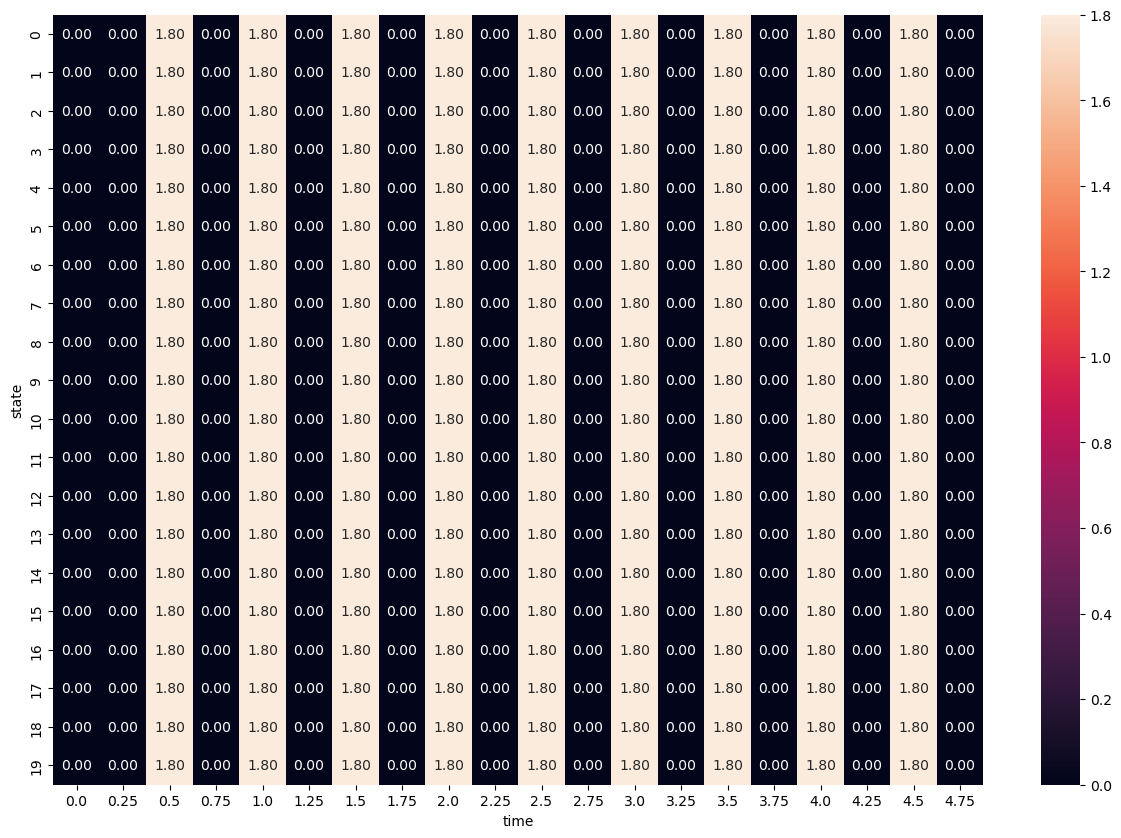

In [114]:
cftree = construct_bond_cftree(T, 4, cpn)
plt.figure(figsize=(15, 10))
sns.heatmap(cftree, annot=True, fmt='.2f')

<Axes: title={'center': 'Bond Price Tree - Dirty Price'}, xlabel='time', ylabel='state'>

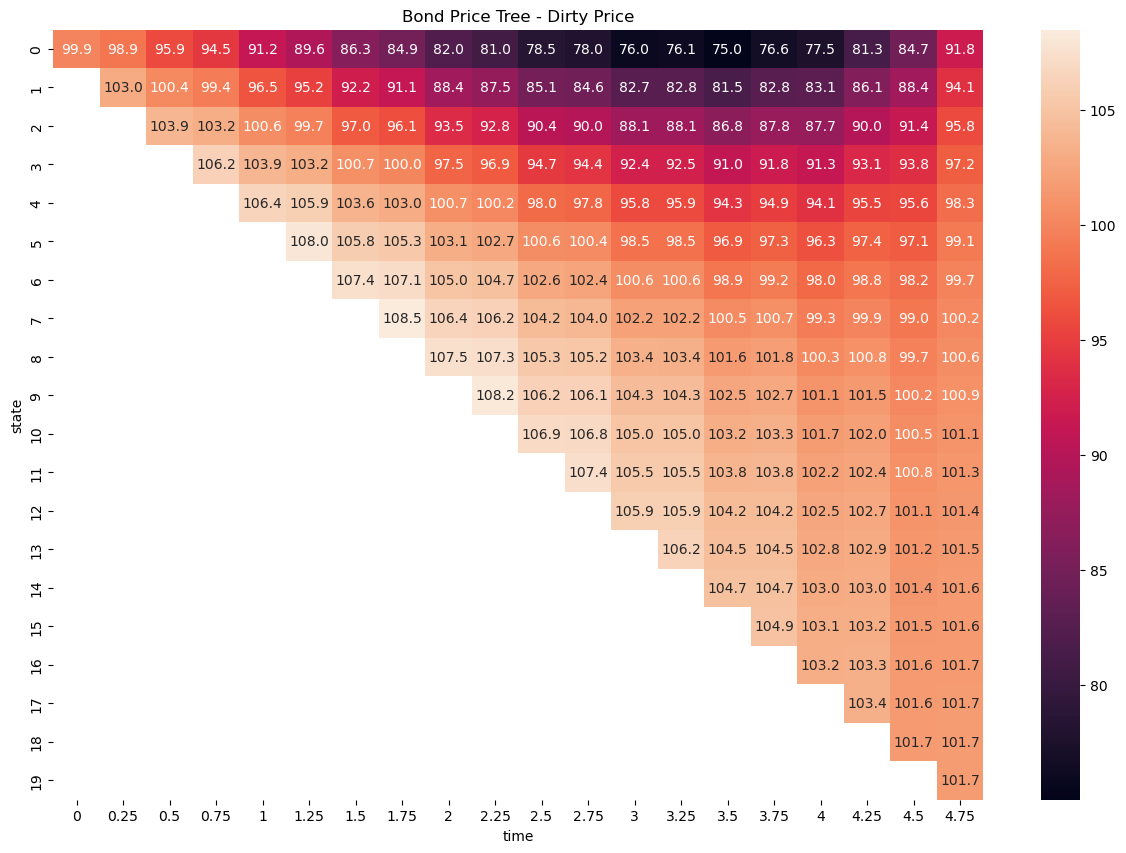

In [122]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

dt = 1/4
tsteps = int(T/dt)
wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=100 * (1+cpn/2))

bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)

plt.figure(figsize=(15, 10))
plt.title('Bond Price Tree - Dirty Price')
sns.heatmap(bondtree, annot=True, fmt='.1f')

<Axes: title={'center': 'Bond Price Tree - Clean Price'}, xlabel='time', ylabel='state'>

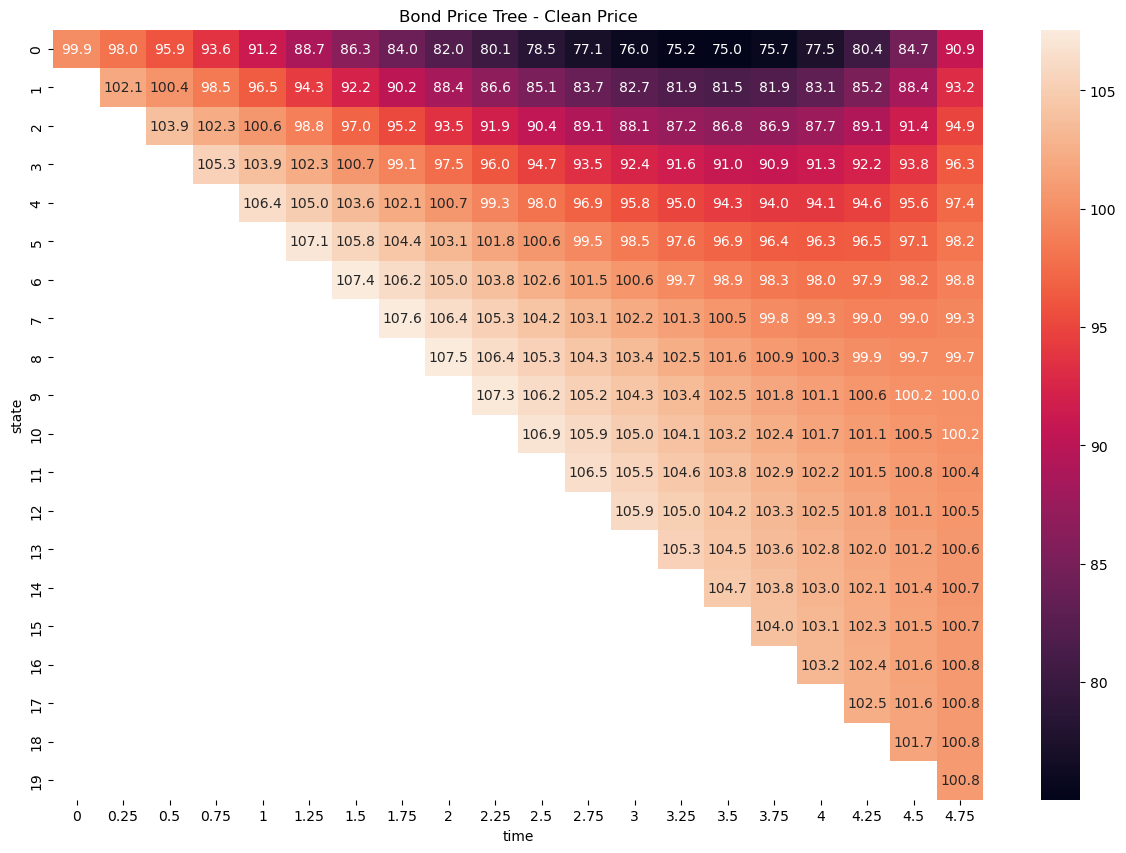

In [121]:
compound = 4
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)

plt.figure(figsize=(15, 10))
plt.title('Bond Price Tree - Clean Price')
sns.heatmap(cleantree, annot=True, fmt='.1f')

### 2.2. (10pts)

Report the tree of bond values.
* Note that there is no distinction betwen clean and dirty values, as the bond pays a coupon quarterly, so every node is immediately after a coupon, at which point clean and dirty are the same.

<Axes: title={'center': 'Bond Price Tree - Clean Price'}, xlabel='time', ylabel='state'>

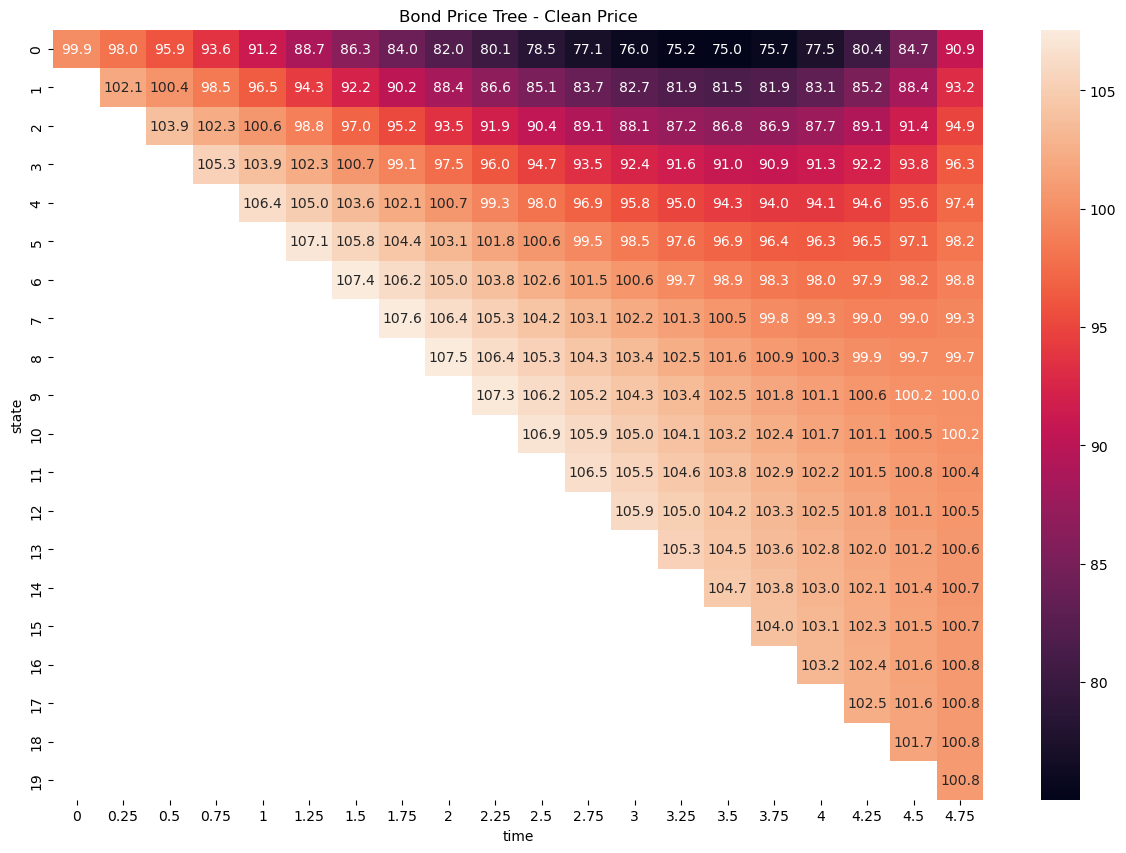

In [123]:
plt.figure(figsize=(15, 10))
plt.title('Bond Price Tree - Clean Price')
sns.heatmap(cleantree, annot=True, fmt='.1f')

### 2.3. (10pts)

Report the cashflow tree of a **structured note** defined below.

* Same maturity as the bond in `2.1`.
* Pays quarterly coupons.

But the coupon is more complicated...
* Coupon is the floating rate (in the tree)
* Paid one quarter later. (So set at $t$ and paid out at $t+.25$)
* Coupon cannot go below `2%` reference rate.
* Coupon cannot go above `5%` reference rate.

Note that unlike a vanilla bond, the cashflow depends on the node of the tree, and it determines the cashflow received one step later.

Thus the cashflow tree should show the cashflow **determined** at that node, even though it is paid out one period later. Given this, you should report the determined cashflow, discounted back one period by the continuously-compounded rate at that same node. So this discounted-determined cashflow is solelly a function of the rate at the node.

#### Careful
You are not being asked to report the **valuation** tree of the structured note--just the cashflow tree.

In [ ]:
import math
def construct_structured_note_cftree(ratetree,
                                     T=5.0,
                                     freq=4,
                                     floor_rate=0.02,
                                     cap_rate=0.05,
                                     notional=100.0):
    dt = 1.0 / freq
    tsteps = int(T * freq)       
    
    cftree = ratetree.iloc[:tsteps, :tsteps].copy()
    cftree[:] = 0.0 
    

    for i in range(tsteps):
        for j in range(i+1):
            rawval = ratetree.iloc[j, i]
            if isinstance(rawval, str) and '%' in rawval:
                r = float(rawval.strip('%')) * 0.01
            else:
                r = float(rawval)
            
            coupon_rate = min(cap_rate, max(floor_rate, r))

            coupon_amount = notional * coupon_rate * dt
            
            df_one_period = math.exp(-r * dt)
            
            discounted_coupon = coupon_amount * df_one_period
            
            cftree.iloc[j, i] = discounted_coupon
    
    last_i = tsteps - 1
    for j in range(last_i+1):
        rawval = ratetree.iloc[j, last_i]
        if isinstance(rawval, str) and '%' in rawval:
            r = float(rawval.strip('%')) * 0.01
        else:
            r = float(rawval)
        
        redemption = notional * math.exp(-r * dt)
        
        cftree.iloc[j, last_i] += redemption
    
    return cftree

structured_cftree = construct_structured_note_cftree(ratetree, T=5, freq=4,
                                                     floor_rate=0.02, cap_rate=0.05, notional=100)


In [154]:
structured_cftree.replace(0, np.nan, inplace=True)

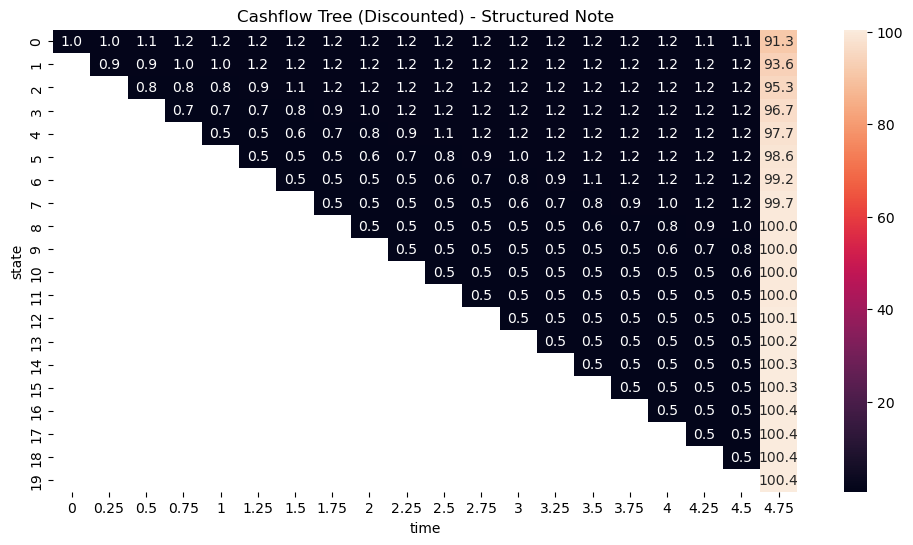

In [155]:
plt.figure(figsize=(12,6))
sns.heatmap(structured_cftree, annot=True, fmt=".1f")
plt.title("Cashflow Tree (Discounted) - Structured Note")
plt.show()

***